GP Regression with GPflow
--

*James Hensman, 2015, 2016*

GP regression (with Gaussian noise) is the most straightforward GP model in GPflow. Because of the conjugacy of the latent process and the noise, the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

This notebook shows how to build a GPR model, estimate the parameters $\theta$ by both maximum likelihood and MCMC. 

## Editted by @fujiisoup

In this note, I checked the updated umplementation where the model reuse with different data becomes possible.

Please see

model.update_data(X,Y)
gpr.update_data(X,Y)
vgp.update_data(X,Y)

In [38]:
import GPflow
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time

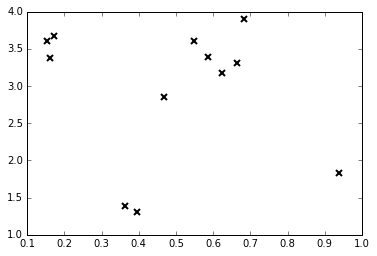

In [39]:
# build a very simple data set:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.figure()
plt.plot(X, Y, 'kx', mew=2)

Maximum Likelihood estimation
--

In [40]:
#build the GPR object
k = GPflow.kernels.Matern52(1)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

In [41]:
print "Here are the parameters before optimization"
m

Here are the parameters before optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.01],None,+ve
model.mean_function.b,[ 0.],None,(none)
model.mean_function.A,[[ 1.]],None,(none)
model.kern.lengthscales,[ 1.],None,+ve
model.kern.variance,[ 1.],None,+ve


In [42]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
2.63434481621  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.0328531],None,+ve
model.mean_function.b,[ 3.27582657],None,(none)
model.mean_function.A,[[-0.87207634]],None,(none)
model.kern.lengthscales,[ 0.08682532],None,+ve
model.kern.variance,[ 0.80792935],None,+ve


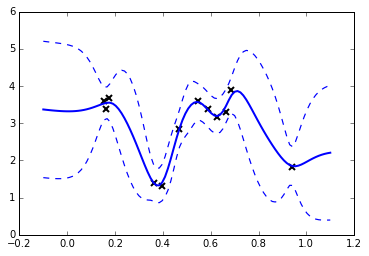

In [43]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data

In [44]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.update_data(X, Y)

In [45]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.138497114182  (s) for optimization


Name,values,prior,constraint
model.likelihood.variance,[ 2.12540632e-08],None,+ve
model.mean_function.b,[ 3.5896873],None,(none)
model.mean_function.A,[[-1.02928222]],None,(none)
model.kern.lengthscales,[ 0.05368647],None,+ve
model.kern.variance,[ 0.59675357],None,+ve


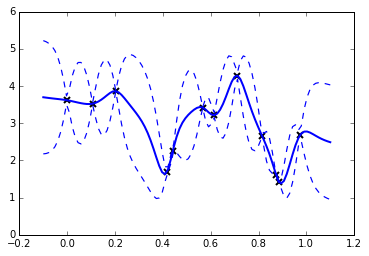

In [46]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### For another data with different shape

In [47]:
# shape changed!
N = 13
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
# update data
m.update_data(X, Y)

In [48]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.701769113541  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 2.12587170e-08],None,+ve
model.mean_function.b,[ 3.46856054],None,(none)
model.mean_function.A,[[-0.65343813]],None,(none)
model.kern.lengthscales,[ 0.02775724],None,+ve
model.kern.variance,[ 0.73037283],None,+ve


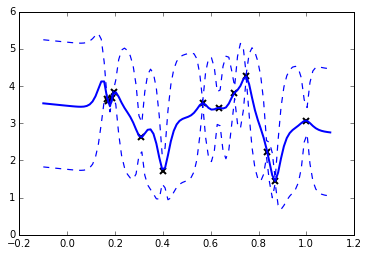

In [49]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

## Fixing the parameters

In [50]:
# Fix the lengthscale
m.kern.lengthscales.fixed = True
m.kern.lengthscales = np.array([0.1,]).reshape(-1,1)

In [51]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for compilation and optimization"
m

compiling tensorflow function...
done
optimization terminated, setting model state
Here are the parameters after optimization
0.678334951401  (s) for compilation and optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.00362114],None,+ve
model.mean_function.b,[ 3.16949089],None,(none)
model.mean_function.A,[[-0.24823793]],None,(none)
model.kern.lengthscales,[ 0.1],None,[FIXED]
model.kern.variance,[ 1.16988676],None,+ve


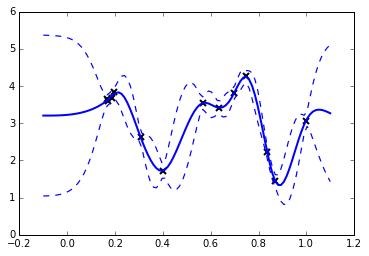

In [52]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

### With different value for fixed param

In [53]:
# Fix the lengthscale
m.kern.lengthscales = np.array([0.2,]).reshape(-1,1)

In [54]:
t = time.time()
m.optimize()
print "Here are the parameters after optimization"
print time.time() - t, " (s) for optimization"
m

optimization terminated, setting model state
Here are the parameters after optimization
0.164916038513  (s) for optimization


Name,values,prior,constraint
model.likelihood.variance,[ 0.00407837],None,+ve
model.mean_function.b,[ 2.29015333],None,(none)
model.mean_function.A,[[ 1.68768156]],None,(none)
model.kern.lengthscales,[ 0.2],None,[FIXED]
model.kern.variance,[ 7.79757384],None,+ve


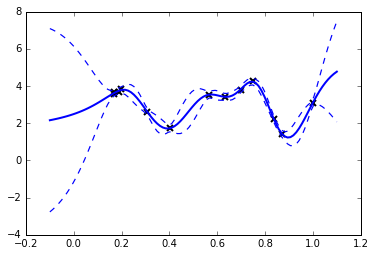

In [55]:
#plot!
xx = np.linspace(-0.1, 1.1, 100)[:,None]
mean, var = m.predict_y(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'b', lw=2)
plt.plot(xx, mean + 2*np.sqrt(var), 'b--', xx, mean - 2*np.sqrt(var), 'b--', lw=1.2)

MCMC
--
First, we'll set come priors on the kernel parameters, then we'll run mcmc and see how much posterior uncertainty there is in the parameters.

In [56]:
m.kern.lengthscales.fixed = False

In [57]:
#we'll choose rather arbitrary priors. 
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.likelihood.variance,[ 0.00407837],"Ga([ 1.],[ 1.])",+ve
model.mean_function.b,[ 2.29015333],"N([ 0.],[ 10.])",(none)
model.mean_function.A,[[ 1.68768156]],"N([ 0.],[ 10.])",(none)
model.kern.lengthscales,[ 0.2],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 7.79757384],"Ga([ 1.],[ 1.])",+ve


In [58]:
samples = m.sample(500, epsilon = 0.1, verbose=1)

compiling tensorflow function...
done


/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/GPflow-0.1.4-py2.7.egg/GPflow/hmc.py:97: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %


/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/GPflow-0.1.4-py2.7.egg/GPflow/hmc.py:101: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  99.0 %


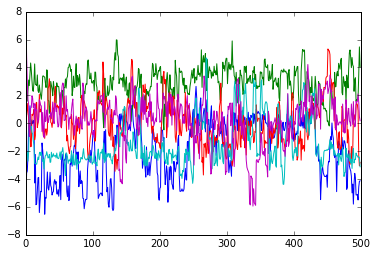

In [59]:
plt.figure()
plt.plot(samples)

/home/keisukefujii/anaconda2/envs/GPflow/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


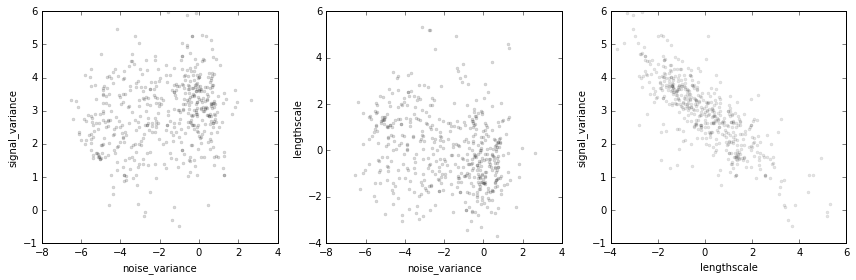

In [60]:
#Note. All these labels are wrong (or, most probably wrong). We need some machinery for labelling posterior samples!

f, axs = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
axs[0].plot(samples[:,0], samples[:,1], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')
axs[1].plot(samples[:,0], samples[:,2], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')
axs[2].plot(samples[:,2], samples[:,1], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

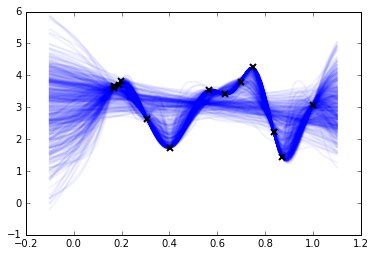

In [61]:
#an attempt to plot the function posterior
#Note that we should really sample the function values here, instead of just using the mean. 
#We are under-representing the uncertainty here. 
# TODO: get full_covariance of the predictions (predict_f only?)

plt.figure()

for s in samples:
    m.set_state(s)
    mean, _ = m.predict_y(xx)
    plt.plot(xx, mean, 'b', lw=2, alpha = 0.05)
    
plt.plot(X, Y, 'kx', mew=2)

## Variational inference

In [62]:
N = 25
X = np.arange(N).reshape(-1,1)
Y = 10.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.

In [63]:
#build the GPR object
k = GPflow.kernels.RBF(1)
lik = GPflow.likelihoods.Poisson()
m = GPflow.vgp.VGP(X, Y, k, likelihood=lik)

In [64]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for compilation and optimization" 

compiling tensorflow function...
done
optimization terminated, setting model state
3.99854898453  (s) for compilation and optimization


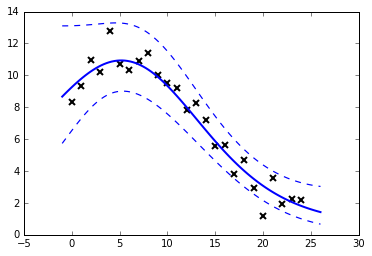

In [65]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)

### For another data with the same shape

In [66]:
Y = 30.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.
m.update_data(X, Y)

In [67]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for optimization" 

compiling tensorflow function...
done
optimization terminated, setting model state
1.32424712181  (s) for optimization


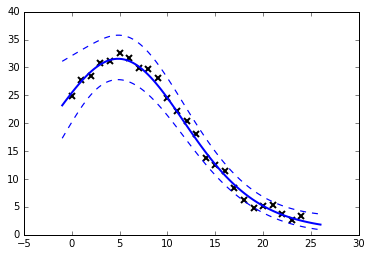

In [68]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)

### For another data with different shape

In [69]:
# shape changed
N = 35
X = np.arange(N).reshape(-1,1)
Y = 14.*np.exp(-((X-np.ones((N,1))*5.)*0.1)**2.) + np.random.rand(N,1)*3.
m.update_data(X, Y)

In [70]:
t = time.time()
m.optimize()
print time.time() - t, " (s) for compilatin and optimization" 

compiling tensorflow function...
done
optimization terminated, setting model state
1.51345491409  (s) for compilatin and optimization


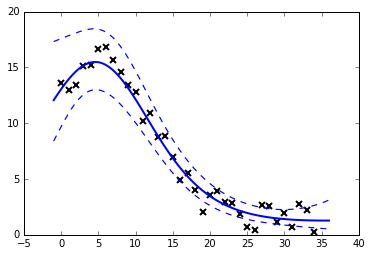

In [71]:
#plot!
xx = np.linspace(-1., N+1., 100)[:,None]
mean, var = m.predict_f(xx)
plt.figure()
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, np.exp(mean), 'b', lw=2)
plt.plot(xx, np.exp(mean + 2*np.sqrt(var)), 'b--', xx, np.exp(mean - 2*np.sqrt(var)), 'b--', lw=1.2)